In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

from keras.models import Model, Sequential

2023-06-21 14:05:16.337168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

data_dir = "../0.data-download/data/"
model_df, effect_df = load_data(data_dir, adult_or_pediatric="all")

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [7]:
# load the latent dimension dataframe

latent_df = pd.read_csv("../2.train-VAE/results/latent_df.csv")

print(latent_df.shape)

latent_df.head(5)

(912, 71)


,ModelID,0,1,2,3,4,5,6,7,8,...,60,61,62,63,64,65,66,67,68,69
0,ACH-001098,0.667955,-0.710161,-1.288565,-0.178892,-0.122788,1.070932,0.008247,-0.141455,-0.632038,...,0.369377,-1.935832,-0.185997,-0.659780,-0.107567,-0.363950,0.848581,1.179960,-0.050720,-0.643959
1,ACH-000191,0.455197,0.192505,0.139463,-1.966845,-0.043970,0.620343,-1.653840,-0.842657,1.978976,...,1.325327,-0.611144,0.467527,1.300587,-0.654522,-0.373168,-0.675906,-0.372202,0.234228,0.253179
2,ACH-001664,1.316046,-2.548526,0.191967,-0.328286,1.294380,-0.359970,-1.311745,-1.135129,0.142615,...,-1.046155,-0.576074,-0.278178,1.916314,0.796305,-2.150311,1.827619,2.006124,-0.261891,-0.423953
3,ACH-002015,1.303492,-0.112393,-1.241137,1.999312,-0.044983,-0.159562,1.581147,1.079809,0.436217,...,-1.876318,0.429358,-1.364914,0.727810,-0.055593,2.557539,-1.266545,0.077816,-0.634921,-0.060857
4,ACH-000550,1.388631,0.263337,1.232808,1.414153,1.681742,-0.795968,1.598389,-0.533899,-1.410749,...,-1.088517,0.298394,0.209960,-0.031674,0.058155,-1.278272,1.686000,0.324850,-1.138205,-0.743968


In [8]:
# create a data frame of both test and train gene effect data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,ModelID,AgeCategory,Sex,train_or_test
0,ACH-001098,Adult,Female,train
1,ACH-000191,Adult,Female,train
2,ACH-001664,Adult,Male,train
3,ACH-002015,Adult,Female,train
4,ACH-000550,Adult,Male,train
...,...,...,...,...
907,ACH-000775,Adult,Female,test
908,ACH-000155,Adult,Male,test
909,ACH-000704,Adult,Female,test
910,ACH-002042,Adult,Female,test


In [9]:
AgeCategory = metadata.pop("AgeCategory")
Sex = metadata.pop("Sex")
train_test = metadata.pop("train_or_test")

/home/ecohen/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


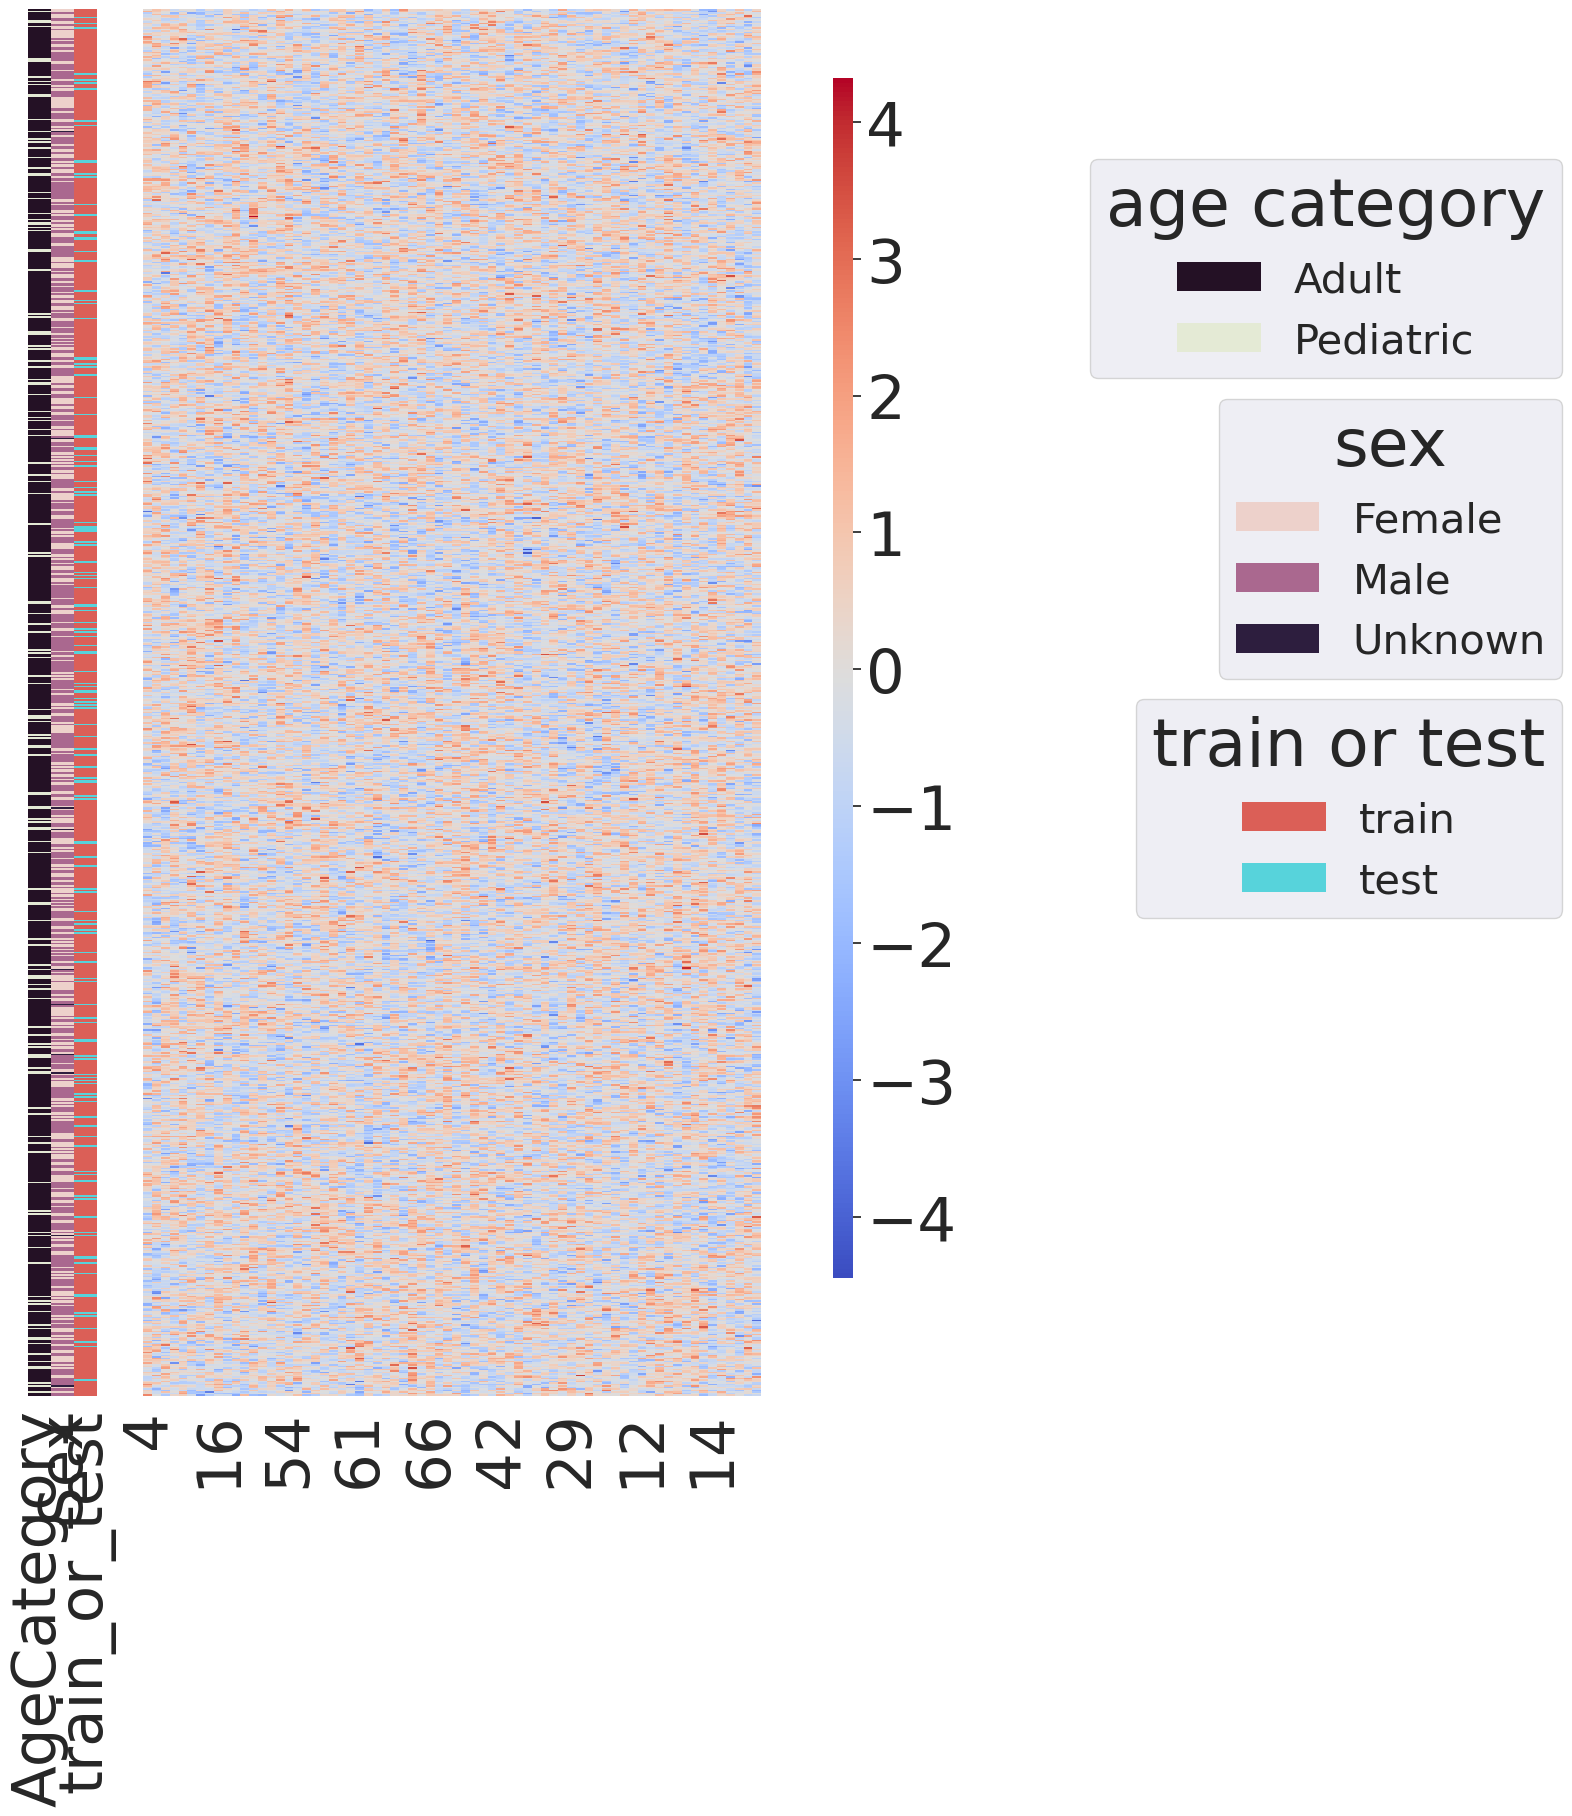

In [10]:
# display clustered heatmap of coefficients
lut_pal = sns.cubehelix_palette(
    AgeCategory.unique().size, light=0.9, dark=0.1, reverse=True, start=1, rot=-2
)
put_pal = sns.cubehelix_palette(Sex.unique().size)
mut_pal = sns.color_palette("hls", train_test.unique().size)

lut = dict(zip(AgeCategory.unique(), lut_pal))
put = dict(zip(Sex.unique(), put_pal))
mut = dict(zip(train_test.unique(), mut_pal))

row_colors1 = AgeCategory.map(lut)
row_colors2 = Sex.map(put)
row_colors3 = train_test.map(mut)

network_node_colors = pd.DataFrame(row_colors1).join(
    pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
)

sns.set(font_scale=4.0)
g = sns.clustermap(
    latent_df.iloc[:,1:],
    method="ward",
    figsize=(10, 20),
    row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)


xx = []
for label in AgeCategory.unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    xx.append(x)
# add the legend
legend3 = plt.legend(
    xx,
    AgeCategory.unique(),
    loc="upper right",
    title="age category",
    ncol=1,
    bbox_to_anchor=(1.75, 0.87),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)


yy = []
for label in Sex.unique():
    y = g.ax_row_dendrogram.bar(0, 0, color=put[label], label=label, linewidth=0)
    yy.append(y)
# add the second legend
legend4 = plt.legend(
    yy,
    Sex.unique(),
    loc="upper right",
    title="sex",
    ncol=1,
    bbox_to_anchor=(1.75, 0.75),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend3)


zz = []
for label in train_test.unique():
    z = g.ax_row_dendrogram.bar(0, 0, color=mut[label], label=label, linewidth=0)
    zz.append(z)
# add the third legend
legend5 = plt.legend(
    zz,
    train_test.unique(),
    loc="upper right",
    title="train or test",
    ncol=1,
    bbox_to_anchor=(1.75, 0.6),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend4)


# save the figure
heat_save_path = pathlib.Path("../1.data-exploration/figures/heatmap.png")
plt.savefig(heat_save_path, bbox_inches="tight", dpi=600)

In [11]:
# load the weights dataframe

gene_weights_df = pd.read_csv("../2.train-VAE/results/weight_matrix_encoder.csv")

gene_weights_df

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.000101,-0.037931,-0.036681,-0.027198,0.043804,-0.037495,0.036276,0.006421,0.008637,0.025438,...,0.004682,0.010450,0.000324,0.004844,0.024128,0.008368,-0.008839,0.006769,0.035937,0.016593
1,-0.011206,0.023624,-0.017611,0.022335,0.034596,-0.042634,0.009411,-0.013815,-0.013696,-0.021911,...,0.005329,-0.037666,-0.012470,-0.003478,0.015595,-0.011644,-0.014867,0.001246,-0.020725,-0.021174
2,-0.014978,-0.039624,-0.023902,0.011588,0.001689,0.027187,0.026177,-0.050210,-0.013767,-0.042664,...,0.023402,-0.013334,-0.049046,0.026138,0.000754,0.013036,0.007455,0.017787,-0.017051,0.007649
3,-0.033118,-0.011848,-0.057877,0.009614,0.018117,0.062050,0.055039,-0.036307,-0.006781,-0.032209,...,0.004676,-0.052899,-0.028335,-0.000572,-0.002464,0.004491,-0.004105,-0.045096,-0.013774,-0.026740
4,-0.015627,0.019984,-0.023834,0.060897,-0.001235,0.035667,-0.020289,0.009512,-0.015328,0.007719,...,0.014733,-0.035435,-0.046767,0.029246,0.017557,0.022444,0.011002,-0.009545,-0.030216,-0.047760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,-0.051695,0.009799,0.039952,-0.022335,0.041122,-0.017752,-0.029779,0.019974,-0.007577,0.039160,...,-0.025529,0.005030,0.038144,0.003369,-0.008515,0.000362,-0.030039,0.021245,-0.038924,-0.010196
2858,-0.003015,0.025731,-0.047497,-0.023807,0.005009,-0.004938,-0.023731,-0.008643,0.012763,-0.014970,...,-0.005867,0.007304,0.035935,-0.014830,0.015345,-0.017101,-0.002296,0.046492,-0.023038,0.029368
2859,0.021145,-0.025917,0.015954,-0.036041,-0.020241,-0.013145,-0.006502,0.018813,0.032679,-0.045174,...,0.043435,-0.020666,0.008482,0.007743,0.027624,-0.000773,0.013500,0.016377,-0.047907,0.002047
2860,-0.007684,-0.041760,0.009414,0.001062,-0.041194,0.019800,-0.000294,-0.002154,-0.019125,0.030030,...,0.012873,0.019250,-0.001811,0.014500,-0.012867,-0.038182,-0.003368,-0.000281,-0.003395,0.030025


/home/ecohen/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


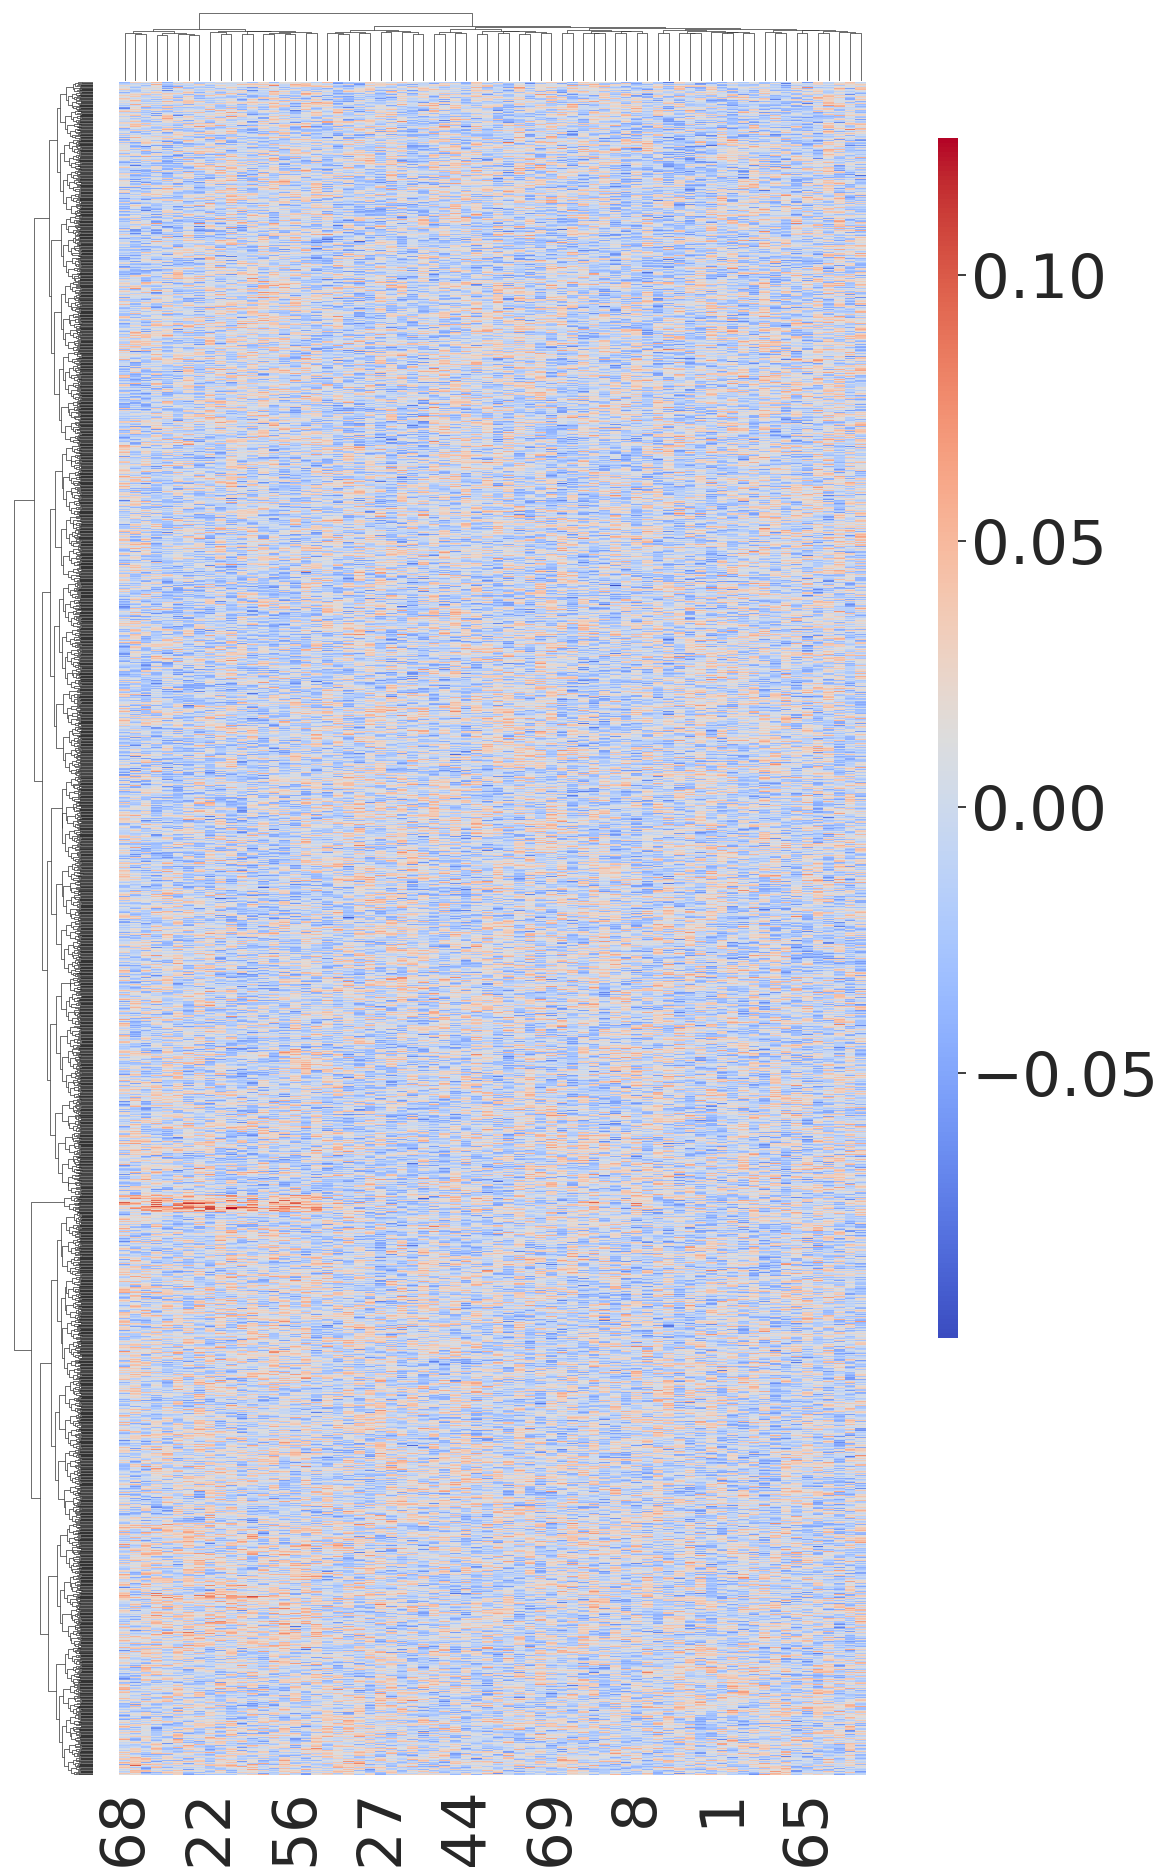

In [12]:
sns.clustermap(
    gene_weights_df,
    method="ward",
    figsize=(10, 20),
    #network_node_colors = pd.DataFrame(row_colors1).join(pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
    #row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
